# Membrane
### References
- https://www.sciencedirect.com/science/article/pii/S0006349508704193
- https://www.sciencedirect.com/science/article/pii/S0006349508707100
- https://doi.org/10.1529/biophysj.107.122945

<img src="../img/membrane.png" width=700 />

**In popc128_700ns, I uploaded a 700-ns simulation of a POPC bilayer system.**
- `conf.pdb`
- `topol.top`
- `grompp.mdp`
- `all.1ns.xtc`: 700-ns trajectory with 1-ns time step.  

(Also You can generate your own membrane system using CHARMM-GUI web server.)

### **topol.top**
```bash
; Include forcefield parameters
#include "amber99sb-ildn.ff/forcefield.itp"

; bonded and non-bonded parameters for lipid
#include "../lipid21.ff/ffnonbonded.lipid21.itp"
#include "../lipid21.ff/ffbonded.lipid21.itp"

; moleculetype definition of POPC lipid
#include "../itps/popc.itp"

; Include water topology
#include "amber99sb-ildn.ff/tip3p.itp"

; Include topology for ions
#include "amber99sb-ildn.ff/ions.itp"

[ system ]
; Name
Protein

[ molecules ]
; Compound        #mols
POPC               128
SOL                 5736
```

### **grommpp.mdp**
The major difference between water box and membrane box is the pressure coupling part.    
- Membrane is not isotropic. Most natural choice for memrbane is semi-isotropic pressure coupling (Pxx = Pyy and Pzz are independent).  
- By setting Pxx = Pyy = 1 bar and Pzz = 1 bar, we can simulate zero surface tension. 
    ```bash
    ; pressure coupling     
    Pcoupl                   = c-rescale
    Pcoupltype               = semiisotropic
    nstpcouple               = -1

    ; Time constant (ps), compressibility (1/bar) and reference P (bar)
    tau-p                    = 1.0
    compressibility          = 4.5e-5 4.5e-5
    ref-p                    = 1      1
    ```


### **Spatial distribution of lipid and water**
- Using `all.1ns.xtc` trajectory file, we can characterize the spatial distributions of water and lipid molecules along the normal direction.  
- gmx density is the program for this purpose.  

    `gmx density -f all.1ns.xtc -d Z -dens mass -sl 30 -ng 2`

    - `-d Z`: density as a function of z. In other words, average over xy plane.
    - `-dens mass`: mass density.
    - `-sl 30`: the number of slices along the z axis.
    - `-ng 2`: the number of groups for analysis.

- Select 2 groups to calculate density for:
    ```bash
    Group     0 (         System) has 34360 elements
    Group     1 (          Other) has 17152 elements
    Group     2 (           POPC) has 17152 elements
    Group     3 (          Water) has 17208 elements
    Group     4 (            SOL) has 17208 elements
    Group     5 (      non-Water) has 17152 elements
    Select a group: 2
    Selected 2: 'POPC'
    Select a group: 4
    Selected 4: 'SOL'
    ```

- Plot `density.xvg` with **gnuplot**  
`gnuplot> pl 'density.xvg' u 1:2 w l title "POPC", 'density.xvg' u 1:3 w l title "water"`  
  
- The membrane has a hydrophobic core of ~3 nm width that has no water molecules at all.
- What is the chance that a water molecule crosses the membrane?  
    We can answer that by calculating ∆G using the umbrella sampling and WHAM.
- Or also you can plt `density.xvg` file with **python** code.

In [19]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.integrate import cumulative_trapezoid

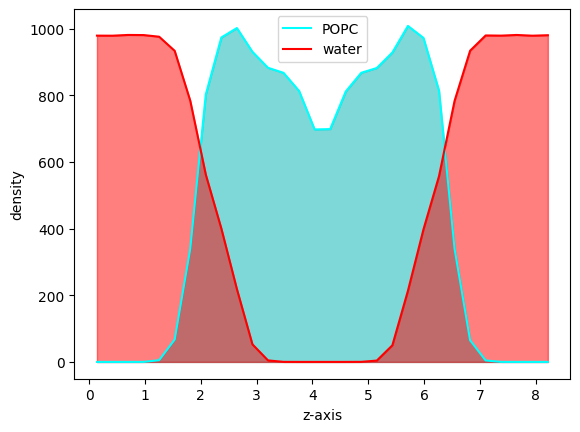

In [7]:
# Load density.xvg file.
dir_path = "/home/wowjason/work/projects/md_lect/3_membrane/popc128_700ns"
density = np.loadtxt(f"{dir_path}/density.xvg", comments=["@", "#"])

plt.figure()

# Plot density of POPC and water.
plt.plot(density[:, 0], density[:, 1], label="POPC", color="cyan")
plt.fill_between(density[:, 0], density[:, 1], color=(0, 0.7, 0.7), alpha=0.5)
plt.plot(density[:, 0], density[:, 2], label="water", color="red")
plt.fill_between(density[:, 0], density[:, 2], color="red", alpha=0.5)

plt.xlabel("z-axis")
plt.ylabel("density")
plt.legend()
plt.show()

<img src="../img/membrane2.png" alt="membrane2" width="500" height="400" style="padding-left: 90px;" />


### **Diffusion of water and lipid**
- Using `all.1ns.xtc` trajectory file, we can compare the diffusion coefficients of water and lipid molecules.  
    Obviously, water diffusion is much faster.
- Homework: calculate the diffusion coefficients of water and lipid by using gmx msd.


### Example of calculating diffusion coefficient of water and POPC
- You have to load trajectory converted by `gmx trjconv` with `-pbc nojump` option

In [8]:
# Load converted trajectory
traj = md.load(f"{dir_path}/nojump.xtc", top=f"{dir_path}/conf.pdb")

# Extract coordinates of POPC(atom P) from full trajectory
selection_P = traj.topology.select("name P")
popc_traj = traj.atom_slice(selection_P)

# Extract coordinates of water(atom OW) from full trajectory
selection_OW = traj.topology.select("resname HOH and name O")
water_traj = traj.atom_slice(selection_OW)

water_popc_xyz = np.concatenate((popc_traj.xyz, water_traj.xyz), axis=1)

# Check
print(f"Number of water: {water_traj.xyz.shape[1]}")
print(f"Number of POPC: {popc_traj.xyz.shape[1]}")
print(f"Number of POPC + water: {water_popc_xyz.shape[1]}")

Number of water: 5736
Number of POPC: 128
Number of POPC + water: 5864


**Calculate MSDs of POPC and water**

$MSD(t)=\frac{1}{N}\displaystyle\sum_{i=1}^{N}\frac{1}{T-t}\displaystyle\sum_{\tau=1}^{T-t}\vert r^{(i)}(\tau+T)-r^{(i)}(\tau) \vert^2$

In [9]:
msds_popc = []
msds_water = []

# Caculating MSD of POPC and water
for n_dt in range(1, water_traj.n_frames):
    displacements = water_popc_xyz[n_dt:, :, :] - water_popc_xyz[:-n_dt, :, :]
    squared_displacements = np.sum(displacements**2, axis=2)
    mean_squared_displacement_popc = np.mean(squared_displacements[:, :128])
    mean_squared_displacement_water = np.mean(squared_displacements[:, 128:])
    msds_water.append(mean_squared_displacement_water)
    msds_popc.append(mean_squared_displacement_popc)

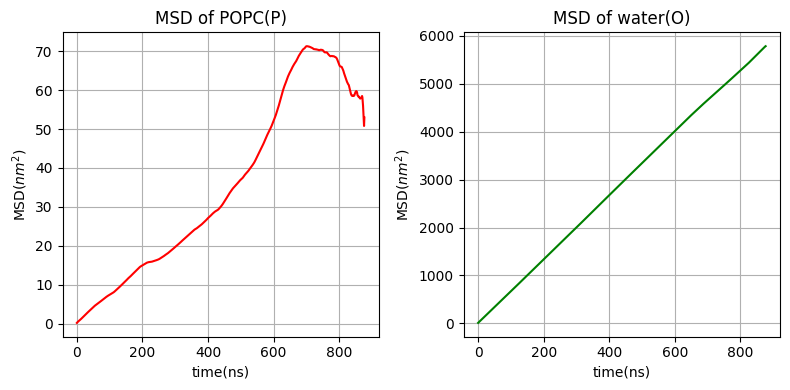

In [10]:
# Plot MSDs
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(msds_popc, color="r")
axs[0].set_title("MSD of POPC(P)")
axs[0].set_xlabel("time(ns)")
axs[0].set_ylabel(r"MSD($nm^2$)")
axs[0].grid()
axs[1].plot(msds_water, color="g")
axs[1].set_title("MSD of water(O)")
axs[1].set_xlabel("time(ns)")
axs[1].set_ylabel(r"MSD($nm^2$)")
axs[1].grid()

plt.tight_layout()
plt.show()

**Calculate Diffusion coefficient**  
$6D\Delta t=MSD$

In [11]:
# Make time array.
time = np.arange(200, traj.n_frames)

# Diffusion coefficient is a slope of MSD.
# Calculate diffusion coefficient of water
slope, _, _, _, _ = linregress(time, msds_water[199:])
diffusion_coefficient_water = slope / 6
diffusion_coefficient_water

# Calculate diffusion coefficient of POPC
slope, _, _, _, _ = linregress(time, msds_popc[199:])
diffusion_coefficient_popc = slope / 6
diffusion_coefficient_popc

print(f"Diffusion coefficient of water: {diffusion_coefficient_water:.4f} x 10\u207B\u2079 (m\u00b2/s)")
print(f"Diffusion coefficient of popc:  {diffusion_coefficient_popc:.4f} x 10\u207B\u2079 (m\u00b2/s)")

Diffusion coefficient of water: 1.0967 x 10⁻⁹ (m²/s)
Diffusion coefficient of popc:  0.0158 x 10⁻⁹ (m²/s)


You can see that diffusion coefficient of water is much larger than popc's

### **Umbrella sampling of a water molecule as a function of the z-position**
- In the ∆G calculation for a water-water pair, the reaction coordinate was the distance between the water pair.
- In this case, the reaction coordinate is the z-position of a water molecule with respect to the center of mass of the membrane.

**Umbrella sampling**
- First, we need to generate the index file  
    We will just select the first water molecule. The selection will not change the results. All water molecules are equal!  
    There are 128 POPC molecules. Thus, the residue index of the first water molecules will be 129.  
`gmx make_ndx -f topol.tpr -o pull.ndx`  
  ```bash
  ri 129
  q
  ```

**Caution: The initial distance between chosen water molecules must be smaller than half of the box. Otherwise, it violated PBC.**  
The groups will look like this:
  ```bash
  0 System              : 34360 atoms
  1 Other               : 17152 atoms
  2 POPC                : 17152 atoms
  3 Water               : 17208 atoms
  4 SOL                 : 17208 atoms
  5 non-Water           : 17152 atoms
  6 r_129               :     3 atoms
  ```

**Perform simulation in each window**
- 10 Å window: See PULL section in pull.10.mdp
    ```bash
    ; COM PULLING          
    pull                     = yes
    ; Cylinder radius for dynamic reaction force groups (nm)
    pull-pbc-ref-prev-step-com = yes
    pull-nstxout             = 50
    pull-nstfout             = 50
    pull-ngroups             = 2
    pull-ncoords             = 1
    pull-group1-name         = POPC
    pull-group1-pbcatom      = 1
    pull-group2-name         = r_129
    pull-coord1-type         = umbrella
    pull-coord1-geometry     = direction
    pull-coord1-vec          = 0 0 1
    pull-coord1-groups       = 1 2
    pull-coord1-dim          = N N Y
    pull-coord1-init         = 1.0         ; the equilibrium length of spring is 10 Å
    pull-coord1-k            = 1000        ; spring constant in kJ/mol nm
    ```

- Generate pull.10.tpr for gmx mdrun      
`gmx grompp -c 2.pdb -f pull.10.mdp -n pull.ndx -o pull.10.tpr -t state.cpt`  
  
    `-t state.cpt`: use information from the check point file.

- Perform MDRUN for 1 ns  
`gmx mdrun -s pull.10.tpr -nt 4 -gpu_id 0 -cpi -noappend -deffnm pull.10 -nsteps 500000`

    pullx files contain the length of spring  
    pullf files contain the force on the spring (F = -kx)

- Repeat same things for other windows. For example, 0, 2, 4, 6, 8 , 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34 Å  
- It will take much longer than the water box. Adjust the simulation time considering your computer.

In [13]:
time = []
force = []

for i in range(8, 35, 2):
    force_path = f"{dir_path}/pull.{i}/pull.{i}_pullf.xvg"
    xvg = np.loadtxt(force_path, comments=["@", "#"])
    time.append(xvg[:, 0])
    force.append(xvg[:, 1])
time = np.array(time)
force = np.array(force)

print(f"Shape of time: {time.shape}")
print(f"Shape of force: {force.shape}")

Shape of time: (14, 100001)
Shape of force: (14, 100001)


**Plot forces**

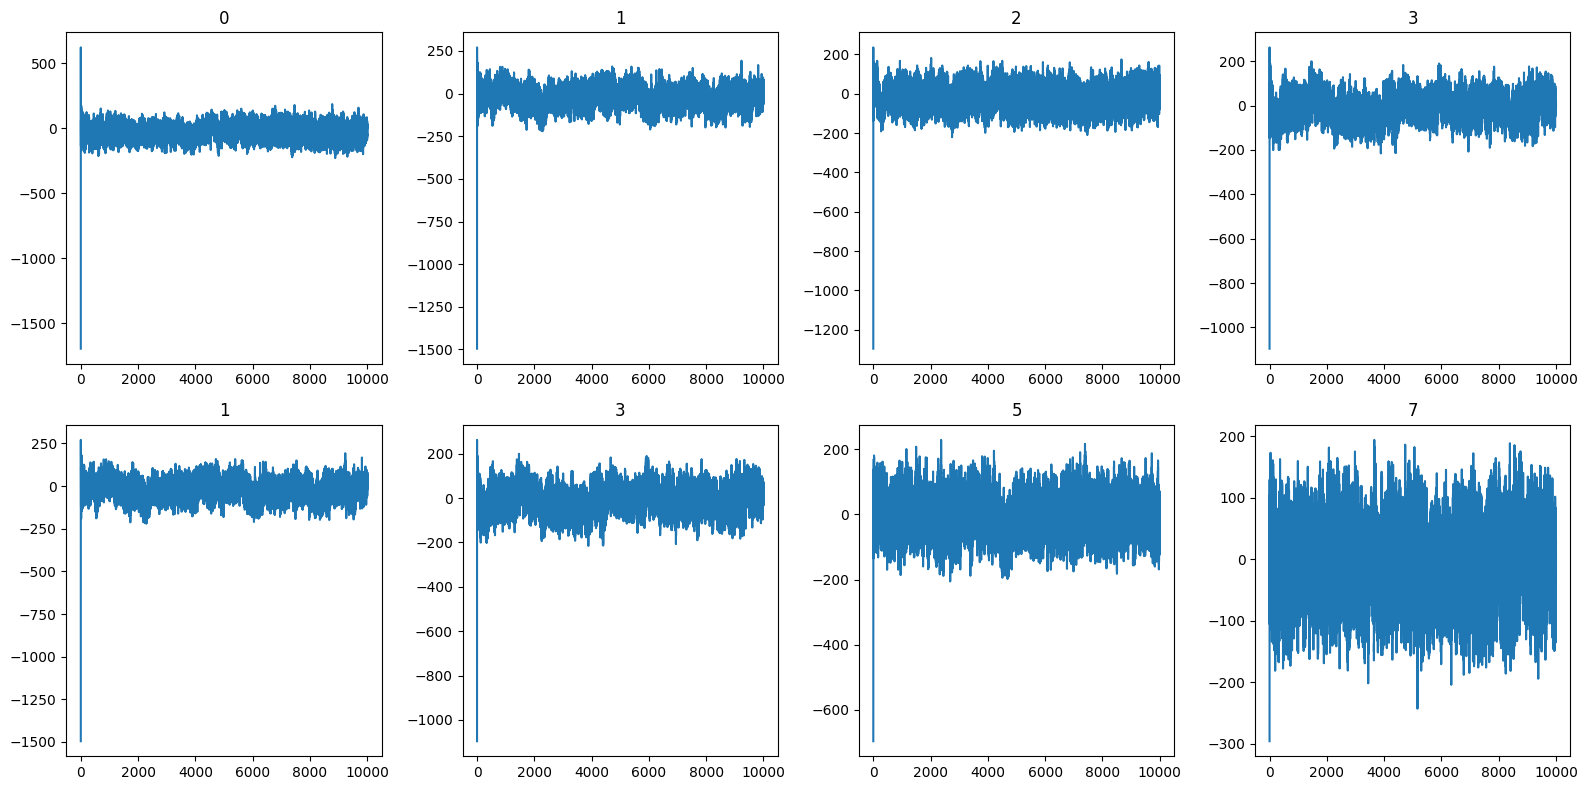

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        axs[i][j].plot(time[(i+1) * (j+1) - 1], force[(i+1) * (j+1) - 1])
        axs[i][j].set_title(f"{(i+1) * (j+1) - 1}")
    
plt.tight_layout()
plt.show()

**Calculate mean forces** 

In [15]:
time_offset = 1000

mean_forces = np.mean(force[:, time_offset*10:], axis=-1)
mean_forces

array([-30.06448261, -23.30788132, -21.45625771,  -7.43049062,
         3.89257537,  -2.61702993,  -2.08482015,  -4.95476062,
        -0.72862993,   0.6438669 ,   0.42652465,  -0.7844652 ,
        -0.46319442,   0.66783837])

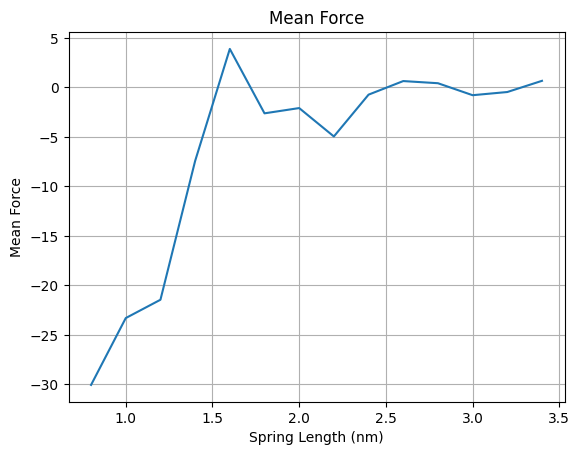

In [17]:
distances = np.arange(0.8, 3.5, 0.2)

plt.figure()
plt.xlabel('Spring Length (nm)')
plt.ylabel('Mean Force')
plt.title('Mean Force')
plt.plot(distances, mean_forces)
plt.grid()
plt.show()

**Calculate and plot PMF**

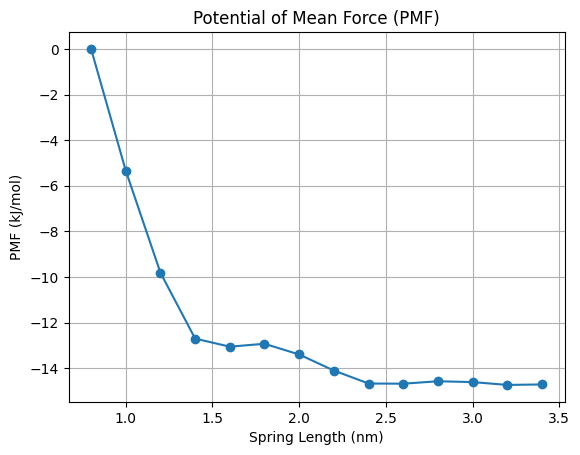

In [20]:
pmf = cumulative_trapezoid(mean_forces, distances, initial=0)

plt.plot(distances, pmf, marker='o')
plt.xlabel('Spring Length (nm)')
plt.ylabel('PMF (kJ/mol)')
plt.title('Potential of Mean Force (PMF)')
plt.grid()
plt.show()